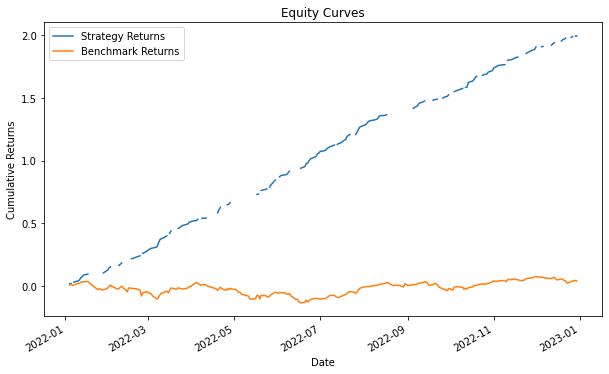

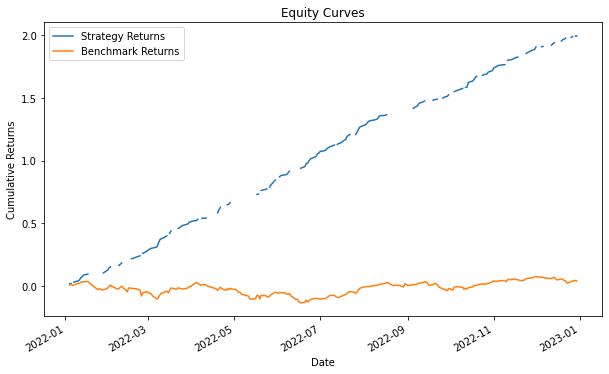

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import base64

app = dash.Dash(__name__)

class StockSelectionStrategy:
    def __init__(self, stock_symbols, start_date, end_date):
        self.stock_symbols = stock_symbols
        self.start_date = start_date
        self.end_date = end_date
        self.benchmark_symbol = '^NSEI'  # NIFTY 50
        self.benchmark_returns = self.get_returns(self.benchmark_symbol)
        self.strategy_returns = self.get_strategy_returns()
        self.portfolio_returns = None  # Initialize as None

    def get_returns(self, symbol):
        data = yf.download(symbol, start=self.start_date, end=self.end_date)
        return data['Close'].pct_change()

    def get_strategy_returns(self):
        strategy_returns = pd.DataFrame(index=self.benchmark_returns.index, columns=self.stock_symbols)

        for symbol in self.stock_symbols:
            stock_returns = self.get_returns(symbol)
            strategy_returns[symbol] = stock_returns

        return strategy_returns

    def select_stocks(self, cur_date):
        positive_returns = self.strategy_returns.loc[cur_date] > 0
        selected_stocks = self.strategy_returns.columns[positive_returns].tolist()
        return selected_stocks

    def simulate_strategy(self):
        portfolio = {}
        portfolio_returns = []

        for cur_date in self.strategy_returns.index:
            selected_stocks = self.select_stocks(cur_date)

            # Revalue portfolio based on selected stocks
            portfolio[cur_date] = selected_stocks
            portfolio_returns.append(self.calculate_portfolio_return(selected_stocks, cur_date))

        # Store portfolio returns as an attribute
        self.portfolio_returns = pd.Series(portfolio_returns, index=self.strategy_returns.index)

        return portfolio, self.portfolio_returns  # Return both portfolio and portfolio returns

    def calculate_portfolio_return(self, selected_stocks, cur_date):
        weighted_returns = self.strategy_returns.loc[cur_date, selected_stocks]
        portfolio_return = weighted_returns.mean()
        return portfolio_return

    def compare_performance_with_benchmark(self):
        benchmark_cagr = ((1 + self.benchmark_returns.mean()) ** 252 - 1) * 100
        strategy_cagr = ((1 + self.portfolio_returns.mean()) ** 252 - 1) * 100

        benchmark_volatility = self.benchmark_returns.std() * (252 ** 0.5)
        strategy_volatility = self.portfolio_returns.std() * (252 ** 0.5)

        benchmark_sharpe_ratio = benchmark_cagr / benchmark_volatility
        strategy_sharpe_ratio = strategy_cagr / strategy_volatility

        return {
            'Benchmark CAGR (%)': benchmark_cagr,
            'Strategy CAGR (%)': strategy_cagr,
            'Benchmark Volatility (%)': benchmark_volatility,
            'Strategy Volatility (%)': strategy_volatility,
            'Benchmark Sharpe Ratio': benchmark_sharpe_ratio,
            'Strategy Sharpe Ratio': strategy_sharpe_ratio
        }


def generate_equity_plot(start_date, end_date, stock_symbols, n_days, initial_equity):
    strategy = StockSelectionStrategy(stock_symbols, start_date, end_date)
    portfolio, strategy_returns = strategy.simulate_strategy()

    # Check if end_date is present in the portfolio
    selected_stocks_text = ', '.join(portfolio.get(end_date, []))

    # Plot equity curves
    plt.figure(figsize=(10, 6))
    strategy_returns.cumsum().plot(label='Strategy Returns')
    strategy.benchmark_returns.cumsum().plot(label='Benchmark Returns')
    plt.title('Equity Curves')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

    # Save the plot as a base64 encoded string
    img = BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    plot_url = base64.b64encode(img.getvalue()).decode()

    return html.Div([
        html.Img(src=f'data:image/png;base64,{plot_url}'),
        html.P(f'Start Date: {start_date}, End Date: {end_date}'),
        html.P(f'Number of Days for Stock Selection: {n_days}'),
        html.P(f'Initial Equity: {initial_equity}'),
        html.Hr(),
        html.H3('Selected Stocks for Sample Strategy:'),
        html.P(selected_stocks_text),
        html.Hr(),
        html.H3('Performance Metrics:'),
        html.P(f'Benchmark CAGR (%): {strategy.compare_performance_with_benchmark()["Benchmark CAGR (%)"]:.2f}'),
        html.P(f'Strategy CAGR (%): {strategy.compare_performance_with_benchmark()["Strategy CAGR (%)"]:.2f}'),
        # Add more performance metrics as needed
    ])


app.layout = html.Div([
    html.H1("Stock Selection Strategy App"),
    html.Label('Start Date'),
    dcc.Input(id='start-date', type='date', value='2022-01-01'),
    html.Label('End Date'),
    dcc.Input(id='end-date', type='date', value='2023-01-01'),
    html.Label('Number of Days for Stock Selection'),
    dcc.Input(id='n-days', type='number', value=30),
    html.Label('Initial Equity'),
    dcc.Input(id='initial-equity', type='number', value=100000),
    html.Button('Generate Equity Plot', id='equity-button'),
    html.Div(id='equity-plot-output'),
])

@app.callback(
    Output('equity-plot-output', 'children'),
    [Input('equity-button', 'n_clicks')],
    [dash.dependencies.State('start-date', 'value'),
     dash.dependencies.State('end-date', 'value'),
     dash.dependencies.State('n-days', 'value'),
     dash.dependencies.State('initial-equity', 'value')]
)
def update_equity_plot(n_clicks, start_date, end_date, n_days, initial_equity):
    if n_clicks is None:
        return None
    return generate_equity_plot(start_date, end_date, ['TCS.BO', 'RELIANCE.BO', 'INFY.BO'], n_days, initial_equity)

if __name__ == '__main__':
    app.run_server(debug=True)


In [2]:
!pip install dash

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 10.2/10.2 MB 3.6 MB/s eta 0:00:00
